- Competition: https://www.kaggle.com/competitions/aerial-cactus-identification/overview
- Dataset: https://www.kaggle.com/competitions/aerial-cactus-identification/data
- Code: https://www.kaggle.com/code/shahules/getting-started-with-cnn-and-vgg16
- Deep Learning: https://www.kaggle.com/learn/intro-to-deep-learning

# 1- Basic model

- How to prepare your data to feed to a neural network
- How convolution neural network works
- How to implement cnn in keras
- How to evaluate your results
- How to use keras pretrained network to improve your model
- How to predit and create a submission

## 1-1 Loading required libraries

In [1]:
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from IPython.display import Image
from keras.preprocessing import image
from keras import optimizers
from keras import layers, models
from keras.applications.imagenet_utils import preprocess_input
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

print(os.listdir('/Users/kenny_jung/aiffel/data/aerial_cactus/'))

from matplotlib import rcParams
rcParams['figure.figsize'] = 13, 6 
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] =False
%config InlineBackend.figure_format = 'retina'


/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


['.DS_Store', 'test', 'submission.csv', 'train', 'train.csv', 'sample_submission.csv']


## 1-2 Setting dataset directories

In [2]:
train_dir = '/Users/kenny_jung/aiffel/data/aerial_cactus/train'
test_dir = '/Users/kenny_jung/aiffel/data/aerial_cactus/test'
train = pd.read_csv('/Users/kenny_jung/aiffel/data/aerial_cactus/train.csv')
df_test = pd.read_csv('/Users/kenny_jung/aiffel/data/aerial_cactus/sample_submission.csv')

In [3]:
print(train.head())
print(train.shape)

                                     id  has_cactus
0  0004be2cfeaba1c0361d39e2b000257b.jpg           1
1  000c8a36845c0208e833c79c1bffedd1.jpg           1
2  000d1e9a533f62e55c289303b072733d.jpg           1
3  0011485b40695e9138e92d0b3fb55128.jpg           1
4  0014d7a11e90b62848904c1418fc8cf2.jpg           1
(17500, 2)


In [4]:
print(train.value_counts('has_cactus'))
print(train.value_counts('has_cactus', normalize=True))

has_cactus
1    13136
0     4364
Name: count, dtype: int64
has_cactus
1    0.750629
0    0.249371
Name: proportion, dtype: float64


In [5]:
print(df_test.head())
print(df_test.shape)
print(df_test.value_counts('has_cactus'))


                                     id  has_cactus
0  000940378805c44108d287872b2f04ce.jpg         0.5
1  0017242f54ececa4512b4d7937d1e21e.jpg         0.5
2  001ee6d8564003107853118ab87df407.jpg         0.5
3  002e175c3c1e060769475f52182583d0.jpg         0.5
4  0036e44a7e8f7218e9bc7bf8137e4943.jpg         0.5
(4000, 2)
has_cactus
0.5    4000
Name: count, dtype: int64


<Axes: xlabel='has_cactus', ylabel='Count'>

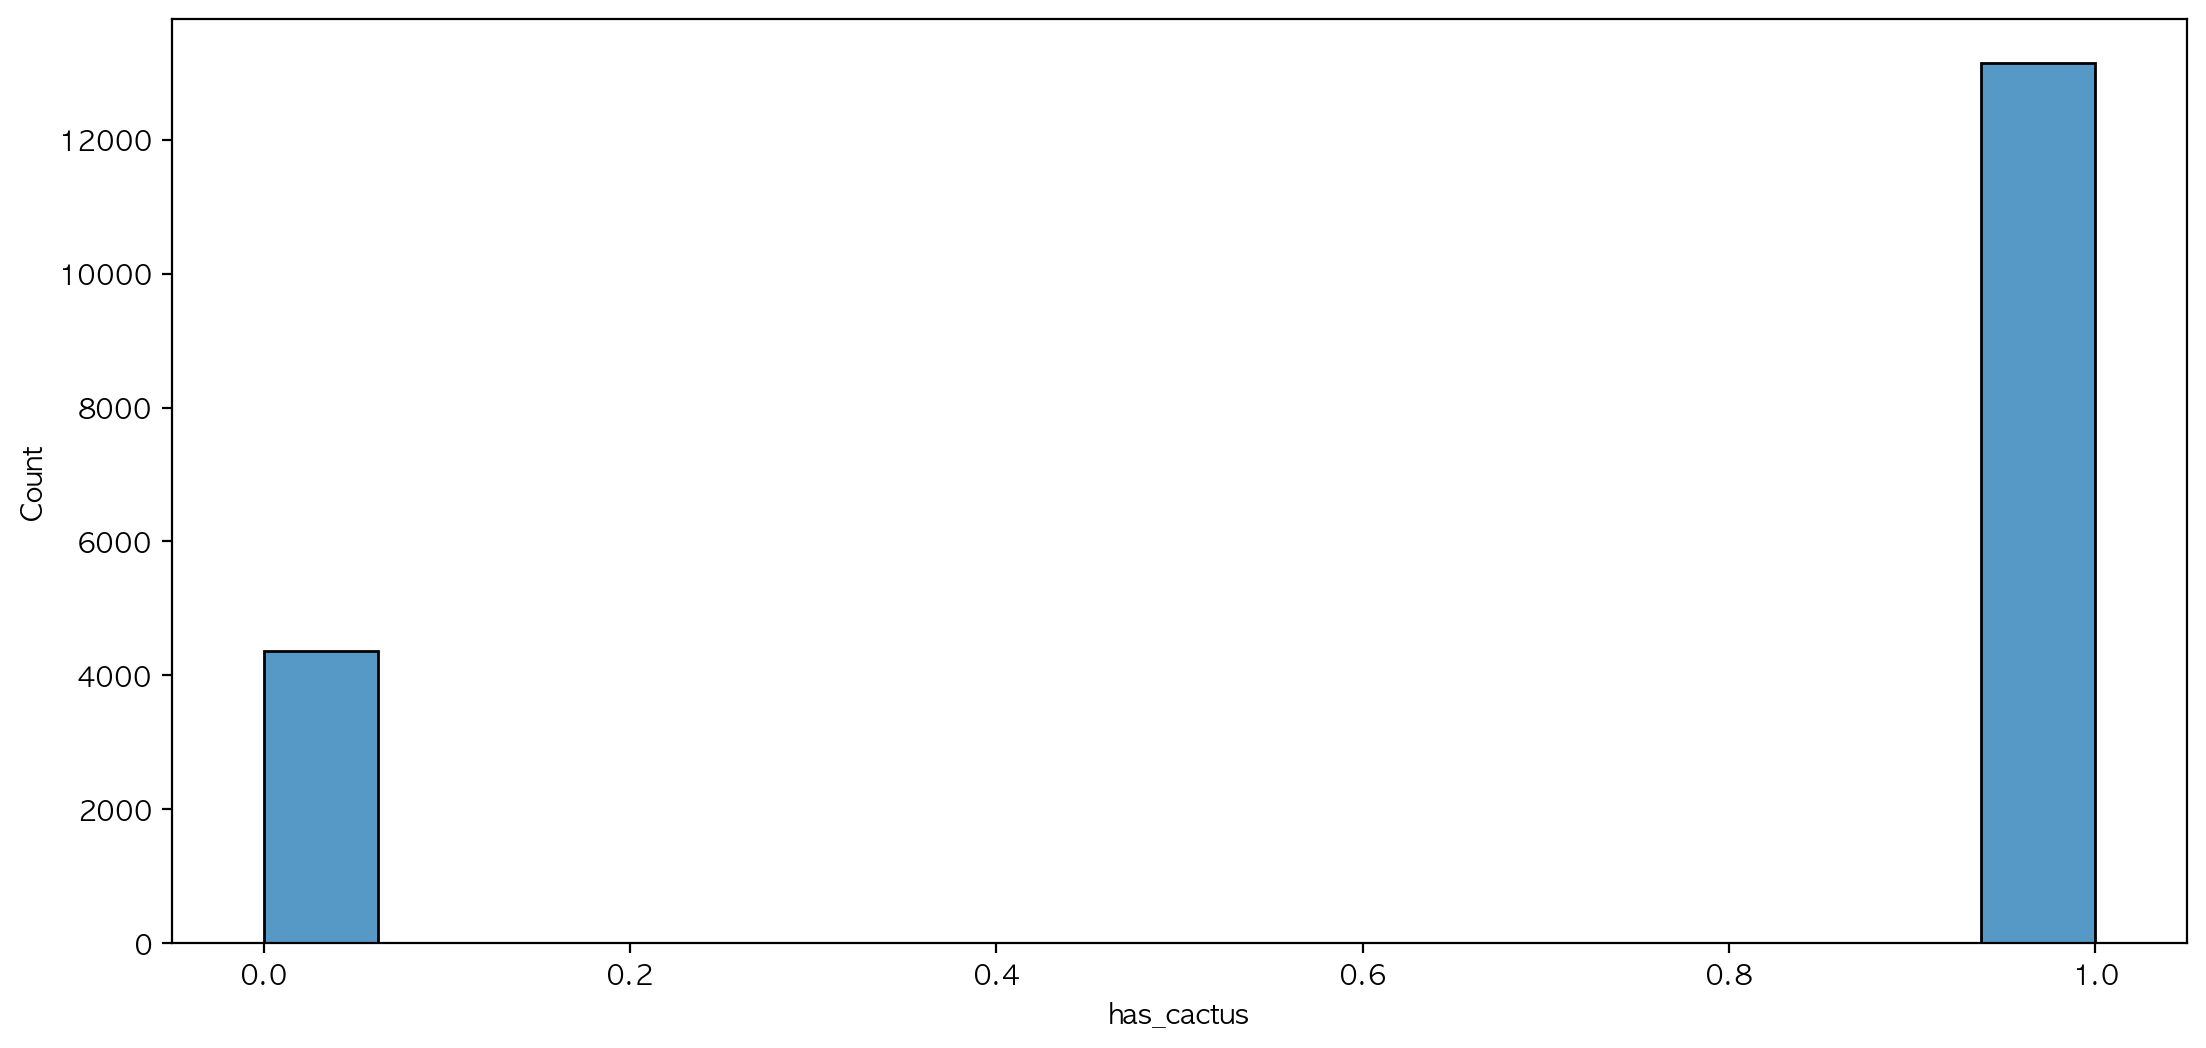

In [6]:
sns.histplot(train['has_cactus'])

## 1-3 Getting a basic idea

In [7]:
train.head(5)
train.has_cactus = train.has_cactus.astype(str)  # Change the data type of the column 'has_cactus' to string

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          17500 non-null  object
 1   has_cactus  17500 non-null  object
dtypes: object(2)
memory usage: 273.6+ KB


In [9]:
print('out dataset has {} rows and {} columns'.format(train.shape[0], train.shape[1]))

out dataset has 17500 rows and 2 columns


In [10]:
train['has_cactus'].value_counts()

has_cactus
1    13136
0     4364
Name: count, dtype: int64

In [11]:
print('The number  of rows in test set is %d'%(len(os.listdir(test_dir))))

The number  of rows in test set is 4000


## 1-4 Displaying image

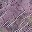

In [13]:
Image(os.path.join(train_dir,train.iloc[3,0]),width=250,height=250)

## 1-5 Data preparation

In [14]:
# Define the parameters of the model
datagen = ImageDataGenerator(rescale = 1./255)  # rescaling images by normalizing the pixel values 
batch_size = 150  # The number of training examples utilized in one iteration

In [15]:
train_generator = datagen.flow_from_dataframe(
    dataframe = train[:15001],  # The first 15000 images are used for training
    directory = train_dir,  # The directory of the training images 
    x_col = 'id',  # The column of the dataframe that contains the filenames of the images
    y_col = 'has_cactus',  # The column of the dataframe that contains the labels of the images 
    class_mode = 'binary',  # The type of the labels
    batch_size = batch_size,  # The number of training examples utilized in one iteration
    target_size = (150, 150)  # The dimensions to which all images found will be resized
)

validation_generator = datagen.flow_from_dataframe(
    dataframe = train[15000:],
    directory = train_dir,
    x_col = 'id',
    y_col = 'has_cactus',
    class_mode = 'binary',
    batch_size = 50,
    target_size = (150, 150)
)

Found 15001 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [17]:
print(train_generator)

In [18]:
# %pip install tensorflow-macos
# %pip install tensorflow-metal

## 1-6 Building our model

In [19]:
model = models.Sequential()  # The sequential model is a linear stack of layers
model.add(layers.Conv2D(32,  # The number of filters
                        (3, 3),  # The dimensions of the convolution window 
                        activation = 'relu',  # The activation function
                        input_shape = (150, 150, 3)))  # The dimensions of the input images
model.add(layers.MaxPool2D((2,2)))  # The dimensions of the pooling window
model.add(layers.Conv2D(64, 
                        (3, 3),
                        activation = 'relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(128,
                        (3, 3),
                        activation = 'relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(128,
                        (3, 3),
                        activation = 'relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())  # Flattens the input
model.add(layers.Dense(512, activation = 'relu'))  # A densely-connected layer with 512 units
model.add(layers.Dense(1, activation = 'sigmoid'))  # A densely-connected layer with 1 unit


2024-03-08 08:55:18.381712: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-03-08 08:55:18.381744: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-03-08 08:55:18.381755: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-03-08 08:55:18.381793: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-08 08:55:18.381811: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


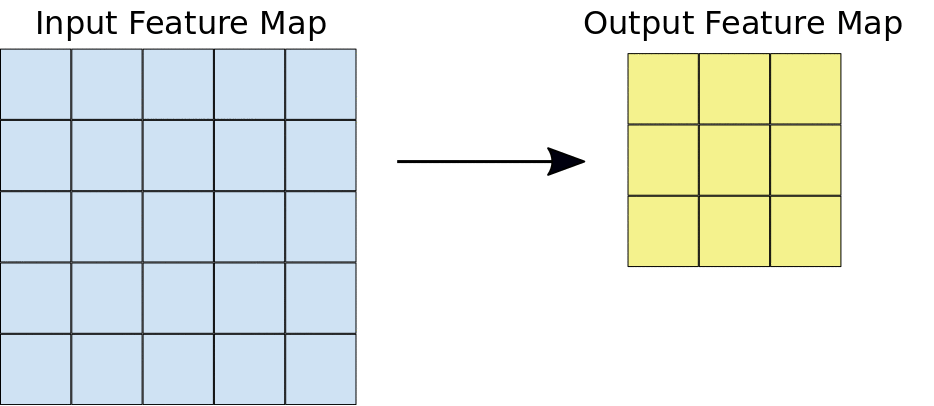

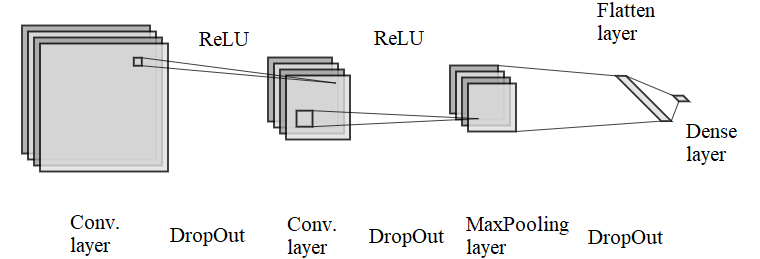

https://www.researchgate.net/figure/The-structure-of-the-CNN-model-two-Convolutional-layers-one-MaxPooling-Flatten-and_fig3_354109692

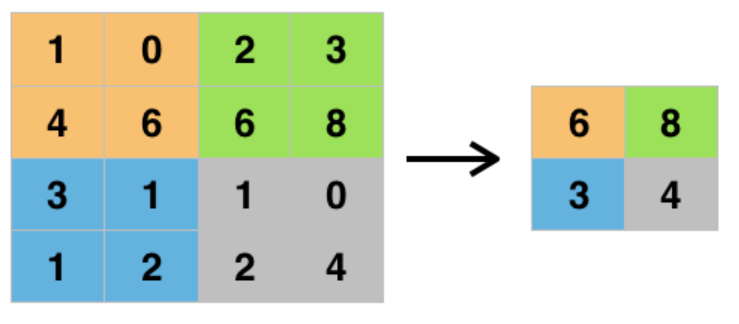

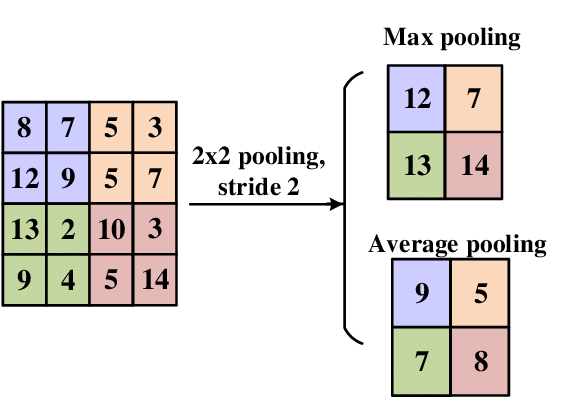

https://www.researchgate.net/figure/Pooling-layer-operation-oproaches-1-Pooling-layers-For-the-function-of-decreasing-the_fig4_340812216

## 1-7 Displaying summary of our network

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

- Conv2D와 MaxPooling2D 레이어는 이미지의 공간적 구조를 이용하여 특징을 추출합니다. Conv2D 레이어는 입력 이미지에 작은 필터를 적용하여 특징 맵을 생성하고, MaxPooling2D 레이어는 특징 맵의 크기를 줄이고 중요한 특징을 강조합니다.
- Flatten 레이어는 2D 특징 맵을 1D 벡터로 변환합니다. 이렇게 하면 Dense 레이어에서 처리할 수 있습니다.
- Dense 레이어는 완전히 연결된 레이어로, 모든 입력 노드가 모든 출력 노드에 연결되어 있습니다. 이 레이어는 모델의 마지막 부분에서 분류 결정을 만드는 데 사용됩니다.
- Param #는 각 레이어의 가중치와 편향의 수를 나타냅니다. 이는 모델의 크기와 복잡성을 나타내는 지표입니다.
- Total params는 모델의 전체 파라미터 수를 나타냅니다. 이 모델은 총 3,453,121개의 파라미터를 가지고 있습니다.
- Trainable params는 훈련 중에 업데이트될 수 있는 파라미터의 수를 나타냅니다. 이 모델에서는 모든 파라미터가 훈련 가능합니다.
- Non-trainable params는 훈련 중에 업데이트되지 않는 파라미터의 수를 나타냅니다. 이 모델에서는 훈련 불가능한 파라미터가 없습니다.

In [148]:
#!pip install pydot
#!pip install graphviz

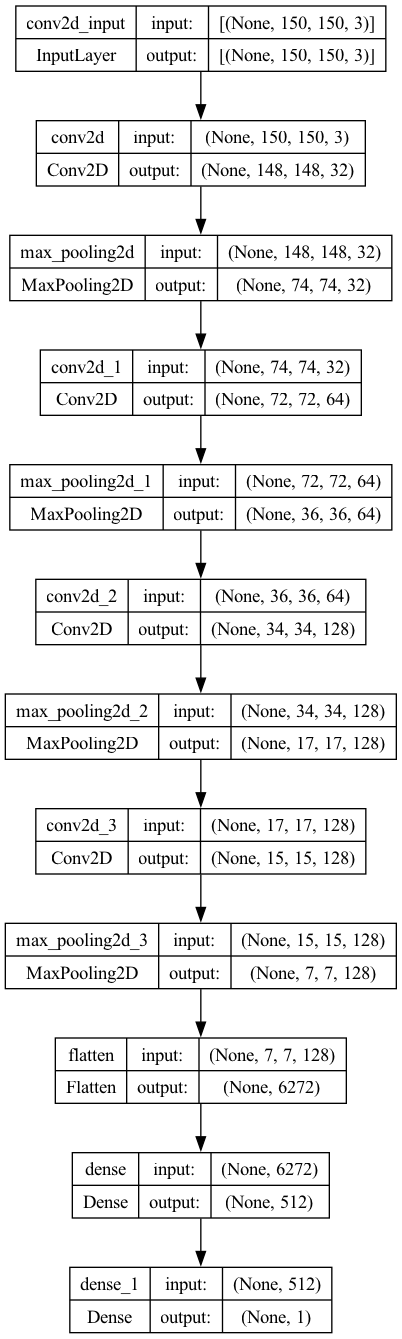

In [23]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

## 1-8 Compiling our model

In [150]:
# # Compile the model with optimizer RMSprop (suboptimal to M1)
# model.compile(loss = 'binary_crossentropy',  # The loss function
#              optimizer = optimizers.RMSprop(),  # The optimizer
#              metrics = ['acc'])  # The metric to monitor

In [24]:
# Compile the model with optimizer 
optimizer = tf.keras.optimizers.legacy.RMSprop()  # Legacy 버전 불러오기
model.compile(loss = 'binary_crossentropy',  # The loss function
             optimizer = optimizer,  # The optimizer
             metrics = ['acc'])          # 모델 compiling

## 1-9 Fitting our model

In [25]:
epochs = 20  # The number of epochs
history = model.fit(
    train_generator,  # The training data
    # steps_per_epoch = 100,  # The number of batches to yield from the generator in one epoch
    epochs = 20,  # The number of epochs
    validation_data = validation_generator,  # The validation data
    validation_steps = 50  # The number of batches to yield from the generator in one epoch 
)

Epoch 1/20


2024-03-08 09:03:24.191658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


101/101 [==============================] - 12s 104ms/step - loss: 0.4735 - acc: 0.8307 - val_loss: 0.7720 - val_acc: 0.8616
Epoch 2/20
101/101 [==============================] - 7s 72ms/step - loss: 2.1955 - acc: 0.7715 - val_loss: 1.8040 - val_acc: 0.4848
Epoch 3/20
101/101 [==============================] - 7s 72ms/step - loss: 2.0142 - acc: 0.8731 - val_loss: 0.3267 - val_acc: 0.9160
Epoch 4/20
101/101 [==============================] - 7s 72ms/step - loss: 0.9245 - acc: 0.8777 - val_loss: 1.6745 - val_acc: 0.7480
Epoch 5/20
101/101 [==============================] - 7s 72ms/step - loss: 2.7836 - acc: 0.6773 - val_loss: 3.6898 - val_acc: 0.7480
Epoch 6/20
101/101 [==============================] - 7s 72ms/step - loss: 1.5878 - acc: 0.7404 - val_loss: 0.8642 - val_acc: 0.7496
Epoch 7/20
101/101 [==============================] - 7s 72ms/step - loss: 0.3122 - acc: 0.8865 - val_loss: 0.1687 - val_acc: 0.9344
Epoch 8/20
101/101 [==============================] - 7s 72ms/step - loss: 0.2

## 1-10 Evaluating our model

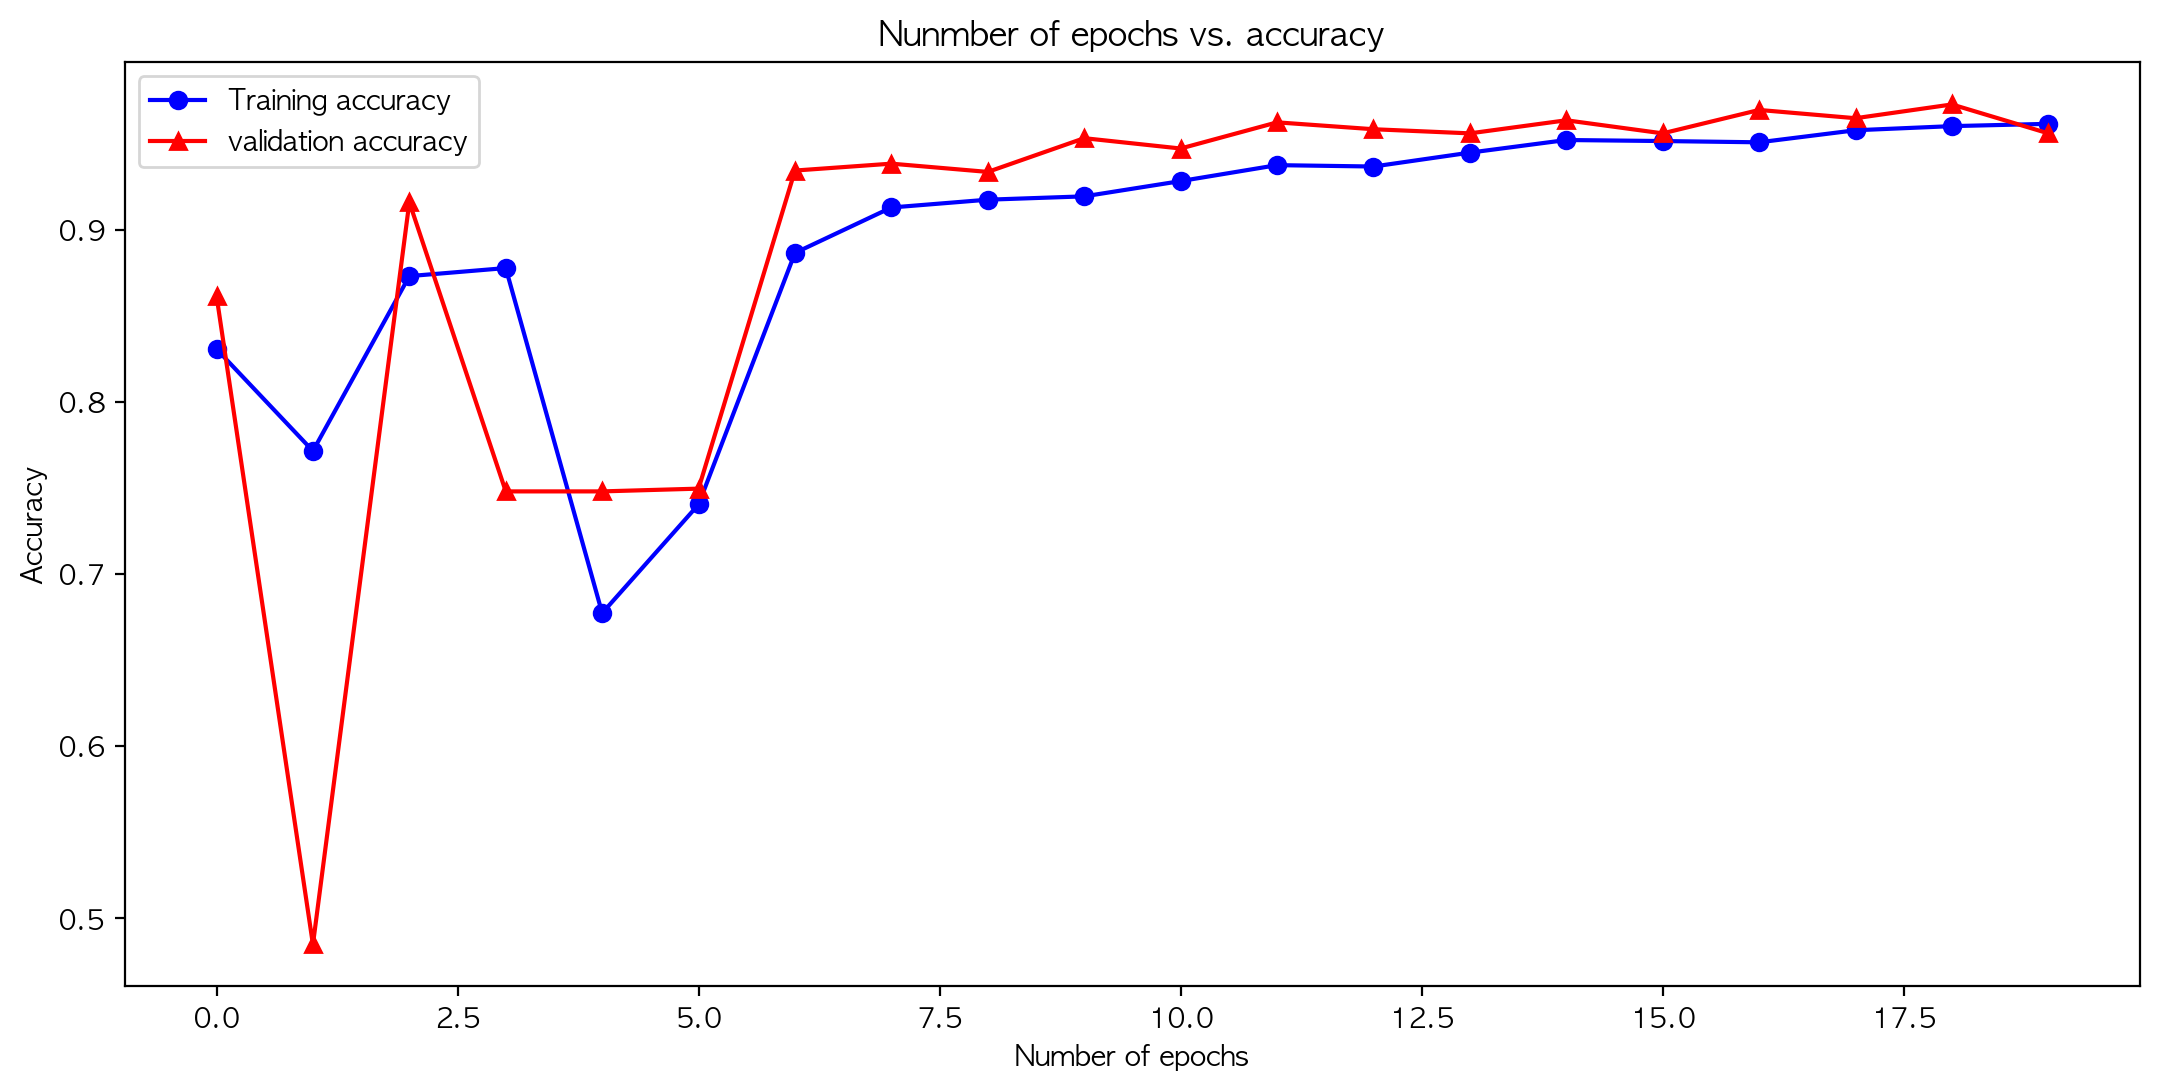

In [26]:
acc = history.history['acc']  ##getting  accuracy of each epochs
epochs_ = range(0,epochs)    
plt.plot(epochs_, acc, label='Training accuracy', color='blue', marker = 'o')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')

acc_val = history.history['val_acc']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label = "validation accuracy", color='red', marker = '^')
plt.title("Nunmber of epochs vs. accuracy")
plt.legend()

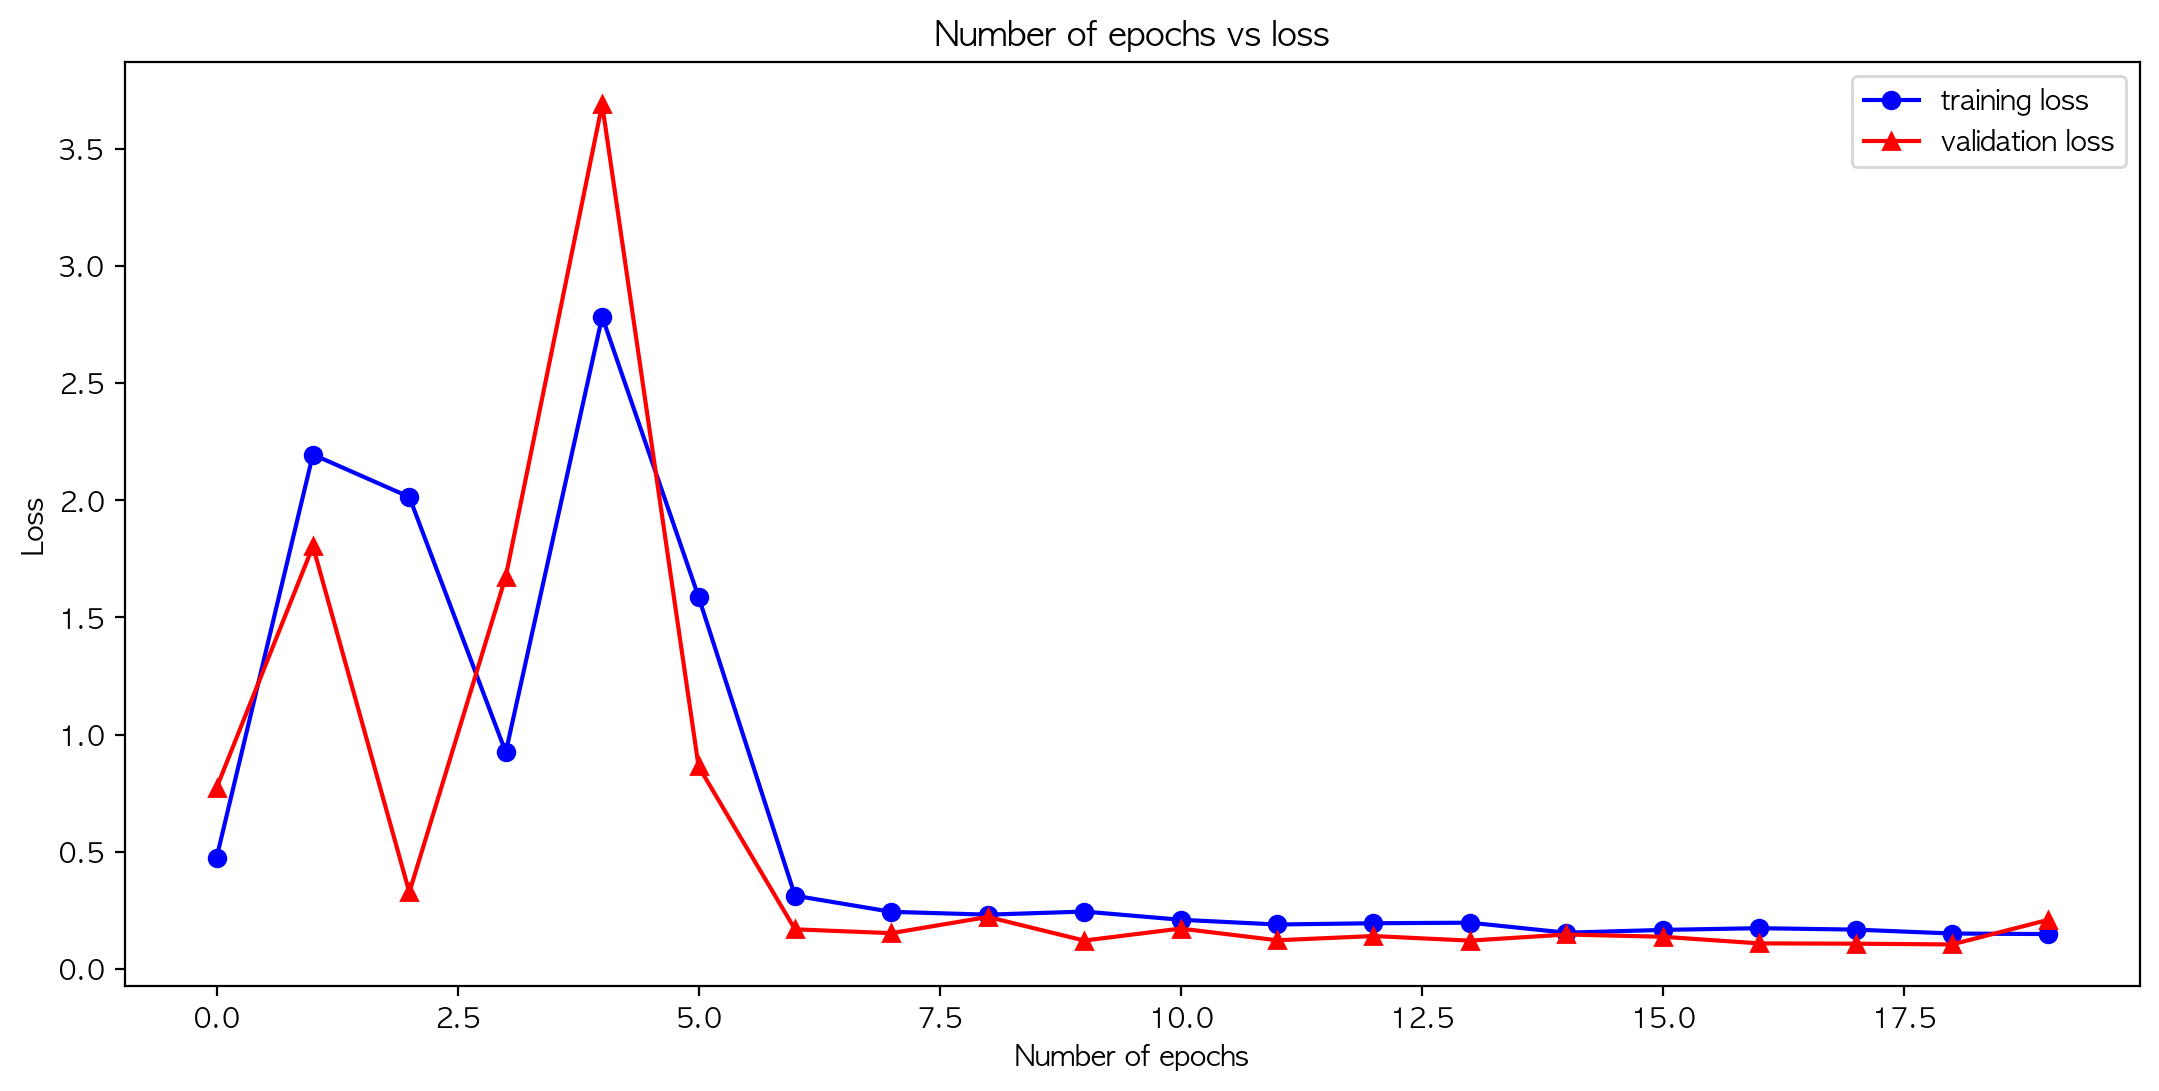

In [27]:
acc=history.history['loss']    ##getting  loss of each epochs
epochs_=range(0,epochs)
plt.plot(epochs_,acc,label='training loss', color='blue', marker = 'o')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')

acc_val=history.history['val_loss']  ## getting validation loss of each epochs
plt.plot(epochs_,acc_val,label="validation loss", color='red', marker = '^')
plt.title('Number of epochs vs loss')
plt.legend()

In [ ]:
log_dir = './logs'

tensor_board_cb = [callbacks.TensorBoard(
    log_dir=log_dir, 
    histogram_freq=1, 
    write_graph=True, 
    write_images=True
)]

model.fit(
    x_train, 
    y_train, 
    batch_size = 32, 
    validation_data = (x_val, y_val),
    epochs = 30, 
    callbacks = tensor_board_cb
)

epochs = 20  # The number of epochs
history = model.fit(
    train_generator,  # The training data
    # steps_per_epoch = 100,  # The number of batches to yield from the generator in one epoch
    epochs = 20,  # The number of epochs
    validation_data = validation_generator,  # The validation data
    validation_steps = 50,  # The number of batches to yield from the generator in one epoch 
    callbacks = tensor_board_cb
)

# 2- Improving our model using VGG16

## 2-1 VGG16 model pre-trained on ImageNet

In [157]:
model_vg = VGG16(weights = 'imagenet', include_top = False)  # The VGG16 model pre-trained on ImageNet
model_vg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

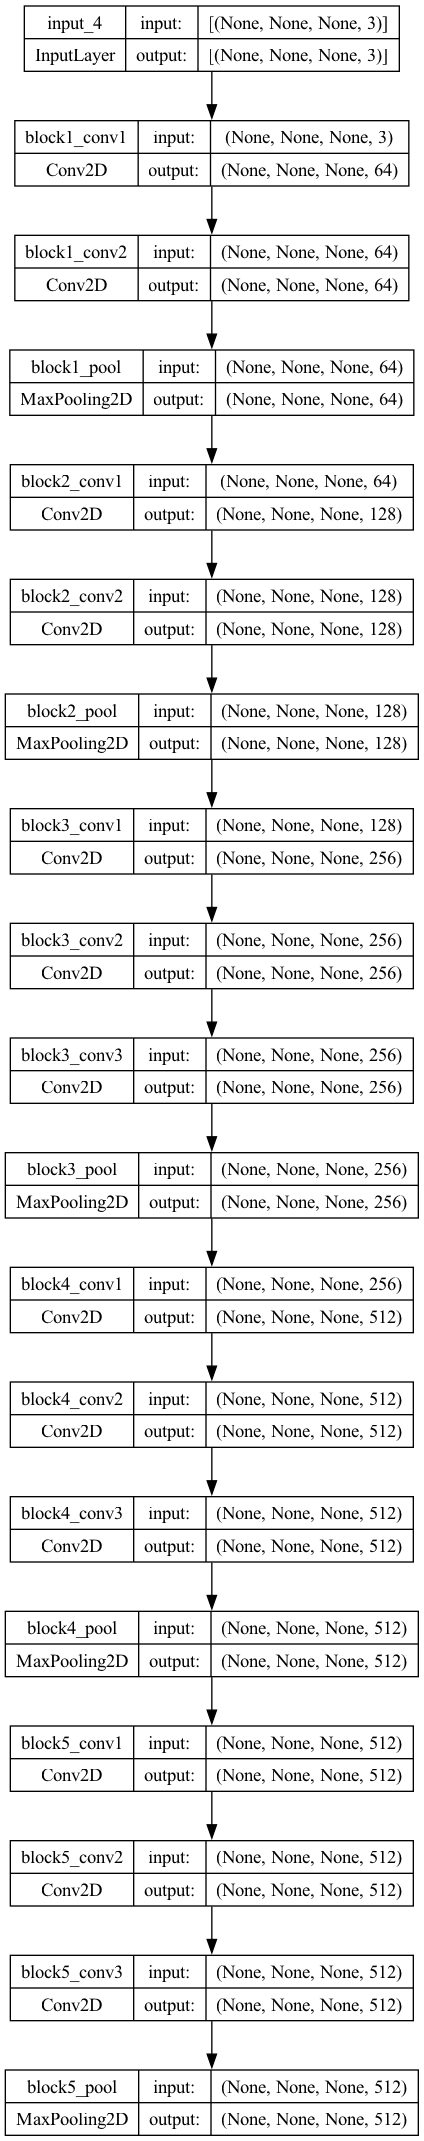

In [158]:
from keras.utils import plot_model
plot_model(model_vg, show_shapes=True)

## 2-2 Extracting features using VGG16

In [101]:
def extract_features(directory, samples, df):  # Extract features from the images
    
    features = np.zeros(shape = (samples, 4, 4, 512))  # The dimensions of the features
    labels = np.zeros(shape = (samples))  # The dimensions of the labels
    generator = datagen.flow_from_dataframe(  # Generate batches of tensor image data with real-time data augmentation
        dataframe = df,  # The dataframe containing the file names and labels
        directory = directory,  # The directory of the images
        x_col = 'id',  #  The column of the dataframe that contains the filenames of the images
        y_col = 'has_cactus',  # The column of the dataframe that contains the labels of the images
        class_mode = 'other',  # The type of the labels
        batch_size = batch_size,  # The number of training examples utilized in one iteration       
        target_size = (150,150))   # The dimensions to which all images found will be resized
    
    i=0
    for input_batch, label_batch in generator:
        feature_batch = model_vg.predict(input_batch)
        features[i*batch_size:(i+1)*batch_size] = feature_batch
        labels[i*batch_size:(i+1)*batch_size] = label_batch
        i+=1
        if(i*batch_size>samples):
            break
    return(features, labels)

train.has_cactus = train.has_cactus.astype(int)  # Change the data type of the column 'has_cactus' to integer
features, labels = extract_features(train_dir, 17500, train)  # Extract features and labels from the training images
train_features = features[:15001]
train_labels = labels[:15001]

validation_features = features[15000:]
validation_labels = labels[15000:]

Found 17500 validated image filenames.


4/4 [==============================] - 0s 68ms/step


In [113]:
print(batch_size)

150


## 2-3 Reshaping our features to feed into our dense layers

In [102]:
#df_test.has_cactus=df_test.has_cactus.astype(str)
test_features, test_labels = extract_features(test_dir, 4000, df_test)

Found 4000 validated image filenames.


4/4 [==============================] - 0s 46ms/step


In [103]:
train_features = train_features.reshape((15001, 4 * 4 * 512))  # Reshape the training features
validation_features = validation_features.reshape((2500, 4 * 4 * 512))  # Reshape the validation features
test_features = test_features.reshape((4000, 4 * 4 * 512))  # Reshape the test features

In [104]:
print(train_features)

[[0.26190674 0.         0.         ... 0.         0.12128168 0.        ]
 [0.         0.         0.         ... 0.         0.86311126 0.        ]
 [0.23494874 0.         0.         ... 0.         0.56255853 0.        ]
 ...
 [0.05537924 0.         0.         ... 0.         0.58728433 0.        ]
 [0.01763064 0.         0.         ... 0.         0.80793178 0.        ]
 [0.         0.         0.         ... 0.         0.53306901 0.        ]]


## 2-4 Building our model

In [121]:
# Define a densely connected network
model = models.Sequential()
model.add(layers.Dense(
    212,
    activation='relu',
    kernel_regularizer=regularizers.l1_l2(.001),
    input_dim=(4*4*512))
)
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation = 'sigmoid'))

## 2-5 Compiling our model

In [122]:
# # Compile the model with optimizer RMSprop (suboptimal to M1)
# model.compile(
#     optimizer = optimizers.RMSprop(),
#     loss = 'binary_crossentropy',
#     metrics = ['acc']
# )

In [123]:
# Compile the model with optimizer 
optimizer = tf.keras.optimizers.legacy.RMSprop()  # Legacy 버전 불러오기
model.compile(loss = 'binary_crossentropy',  # The loss function
             optimizer = optimizer,  # The optimizer
             metrics = ['acc'])          # 모델 compiling

## 2-6 Fitting our model

In [124]:
# epochs = 10  # The number of epochs
# history = model.fit(
#     train_generator,  # The training data
#     steps_per_epoch = 100,  # The number of batches to yield from the generator in one epoch
#     epochs = 10,  # The number of epochs
#     validation_data = validation_generator,  # The validation data
#     validation_steps = 50  # The number of batches to yield from the generator in one epoch 
# )

In [125]:
epochs = 20
history = model.fit(
    train_features,  # The training features
    train_labels,  # The training labels
    epochs = 20,  # The number of epochs
    batch_size = 150,  #
    validation_data=(validation_features, validation_labels)
)

Epoch 1/20
101/101 [==============================] - 3s 22ms/step - loss: 3.2697 - acc: 0.8463 - val_loss: 1.2373 - val_acc: 0.9228
Epoch 2/20
101/101 [==============================] - 2s 17ms/step - loss: 1.3278 - acc: 0.8769 - val_loss: 2.2351 - val_acc: 0.4828
Epoch 3/20
101/101 [==============================] - 2s 17ms/step - loss: 1.2525 - acc: 0.8963 - val_loss: 1.1243 - val_acc: 0.9436
Epoch 4/20
101/101 [==============================] - 2s 17ms/step - loss: 1.1980 - acc: 0.9073 - val_loss: 1.1009 - val_acc: 0.9560
Epoch 5/20
101/101 [==============================] - 2s 17ms/step - loss: 1.1653 - acc: 0.9208 - val_loss: 1.1677 - val_acc: 0.9128
Epoch 6/20
101/101 [==============================] - 2s 17ms/step - loss: 1.1509 - acc: 0.9253 - val_loss: 1.1210 - val_acc: 0.9416
Epoch 7/20
101/101 [==============================] - 2s 17ms/step - loss: 1.1304 - acc: 0.9301 - val_loss: 1.0902 - val_acc: 0.9480
Epoch 8/20
101/101 [==============================] - 2s 17ms/step - 

## 2-7 Evaluating our model

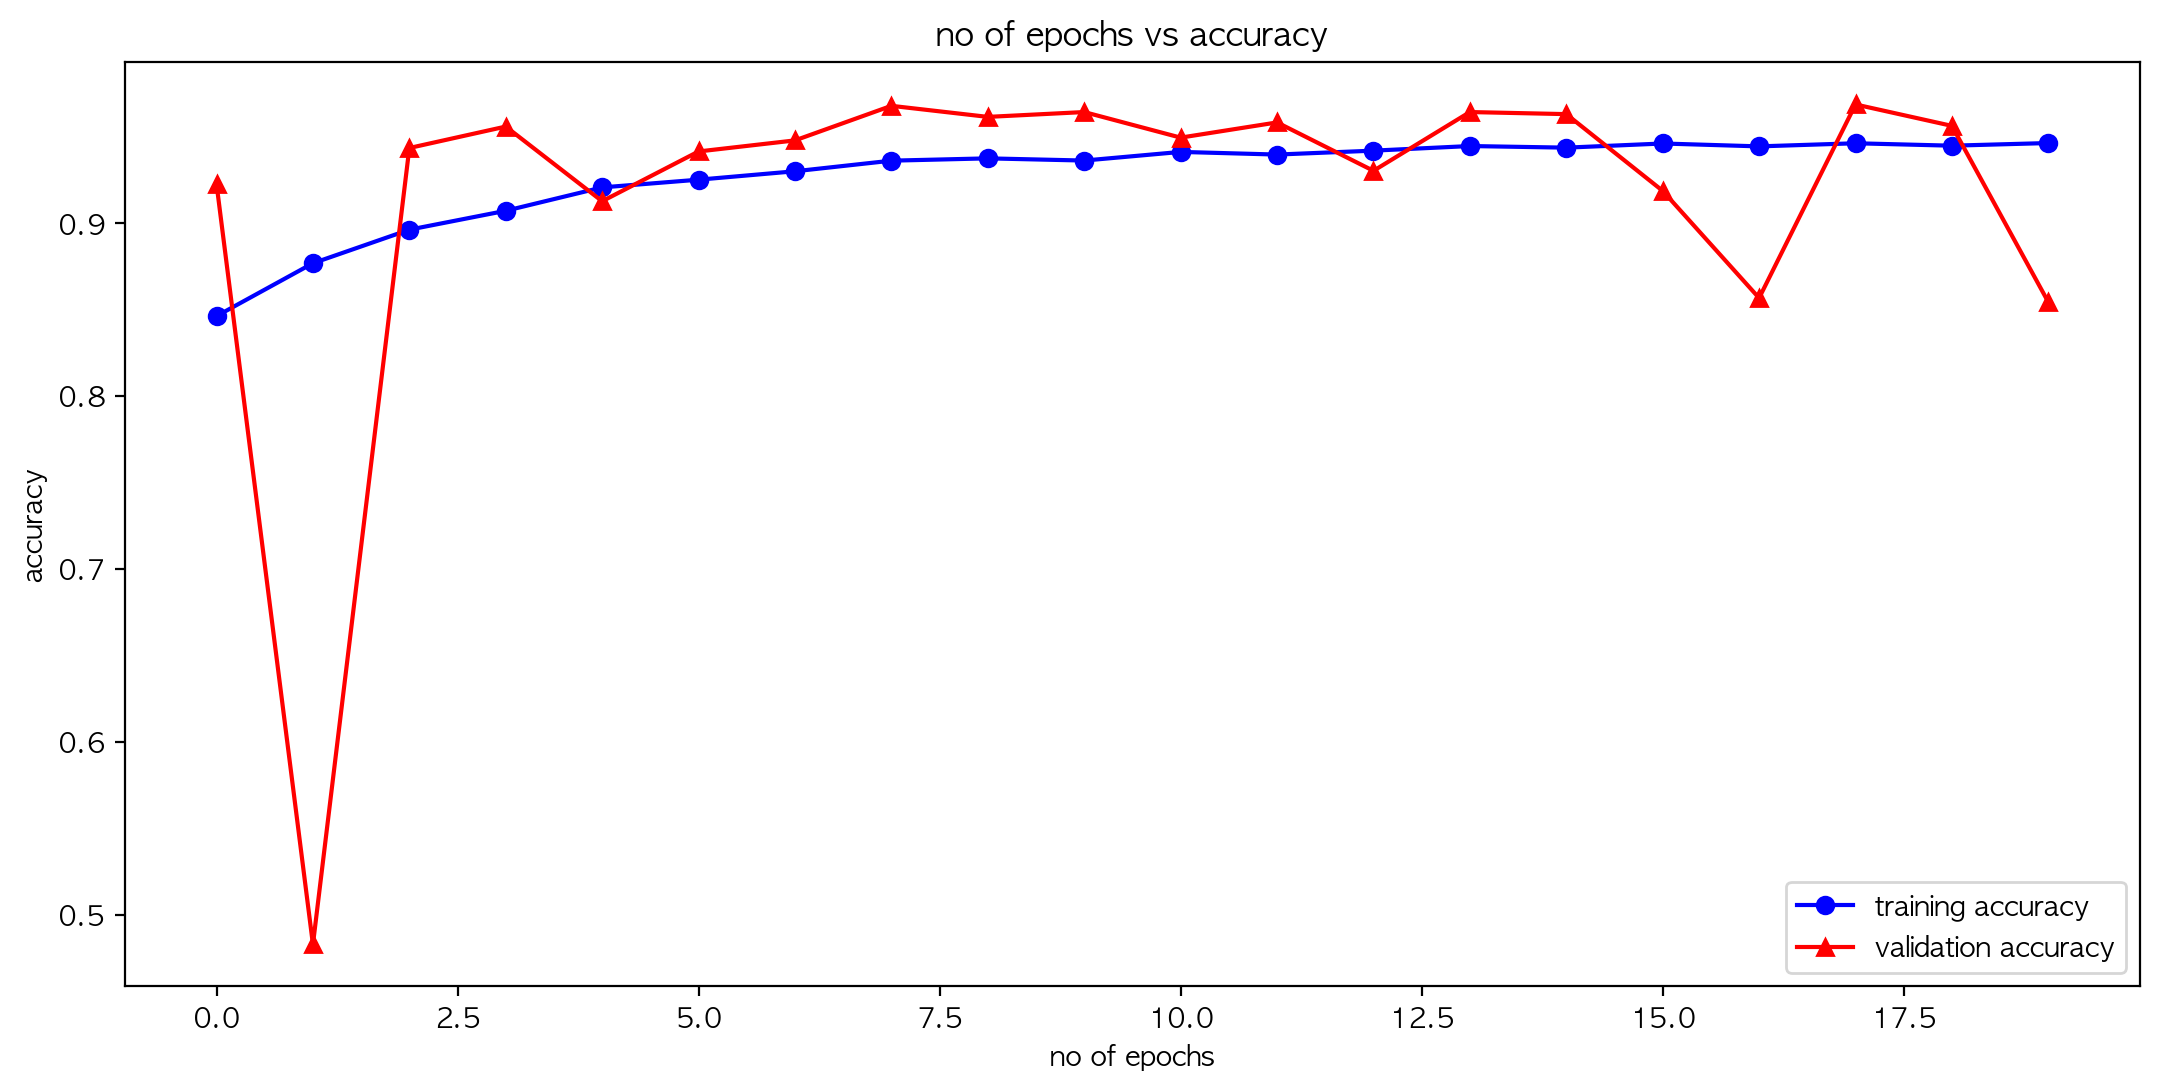

In [126]:
acc = history.history['acc']  ##getting  accuracy of each epochs
epochs_ = range(0, epochs)    
plt.plot(epochs_, acc, label='training accuracy', color='blue', marker = 'o')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

acc_val=history.history['val_acc']  ##getting validation accuracy of each epochs
plt.plot(epochs_, acc_val, label="validation accuracy", color='red', marker = '^')
plt.title("no of epochs vs accuracy")
plt.legend()

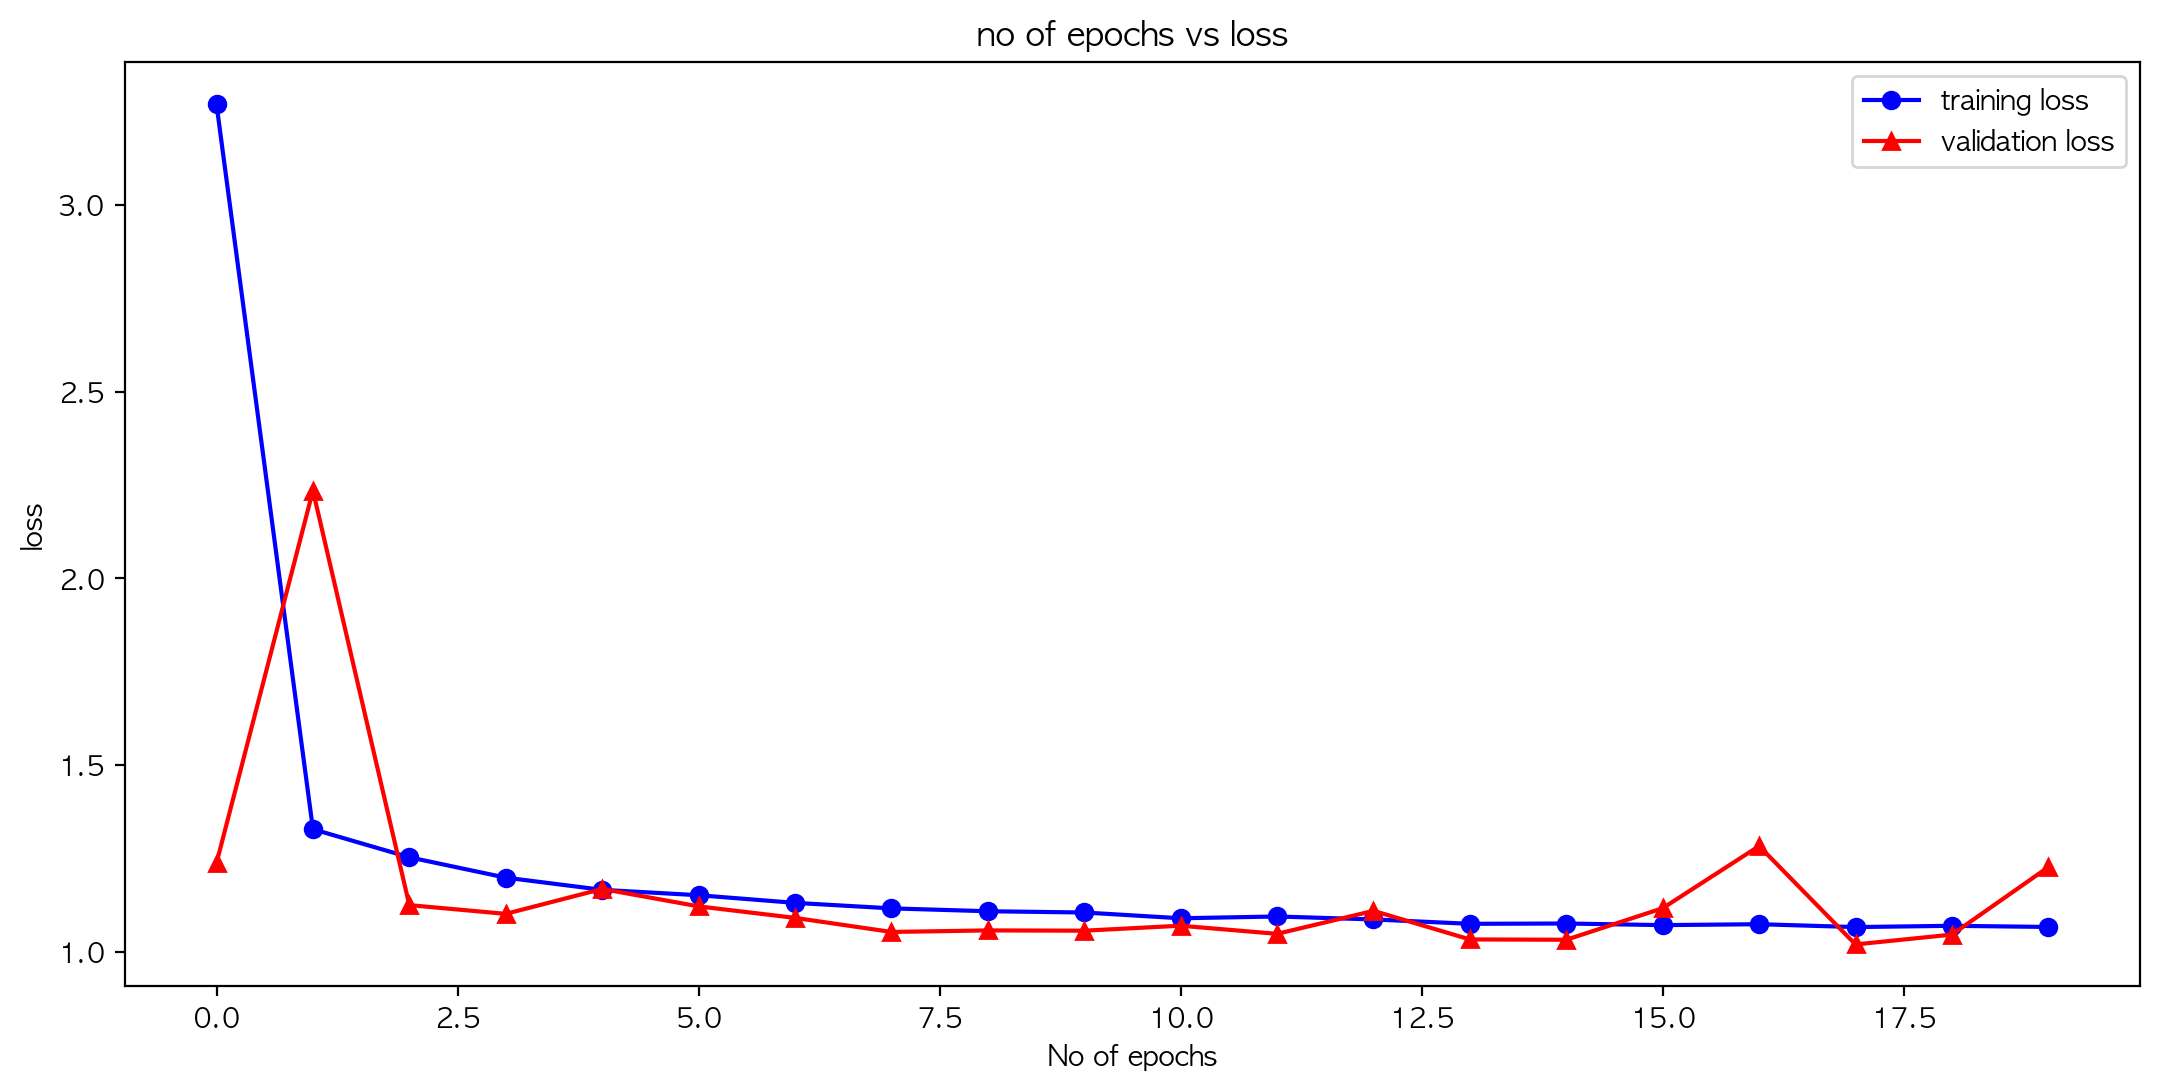

In [127]:
acc=history.history['loss']    ##getting  loss of each epochs
epochs_=range(0,epochs)
plt.plot(epochs_,acc,label='training loss', color='blue', marker = 'o')
plt.xlabel('No of epochs')
plt.ylabel('loss')

acc_val=history.history['val_loss']  ## getting validation loss of each epochs
plt.plot(epochs_,acc_val,label="validation loss", color='red', marker = '^')
plt.title('no of epochs vs loss')
plt.legend()

## 

# 3- Making prediction

In [101]:
y_pre = model.predict(test_features)


 20/125 [===>..........................] - ETA: 0s

125/125 [==============================] - 0s 3ms/step


# 4- Making a submission

In [102]:
df = pd.DataFrame({'id': df_test['id']})
df['has_cactus'] = y_pre
df.to_csv('/Users/kenny_jung/aiffel/data/aerial_cactus/submission.csv', index=False)